In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet.models import retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


import matplotlib.pyplot as plt
import cv2
import sys
import os
import numpy as np
import time
import json

import tensorflow as tf

def get_session():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
sys.path.insert(0, '../keras-retinanet/keras_retinanet')
from utils.gpu import setup_gpu

# use this to change which GPU to use
gpu = '1'

# set the modified tf session as backend in keras
setup_gpu(gpu)

In [5]:

model_path = '../Data/final_model_elephant_seal17_best.h5'
model = models.load_model(model_path, backbone_name='resnet50')

#print(model.summary())

labels_to_names = {"0":"cow","1":"bull","2":"pup"}

In [19]:
image_dir = '../Images/Elephant_Seals_Beach_Only'
image_list = []
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.lower().endswith(('.png')):
            if filename == '2_14_2018_es_db_59---17.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '2_14_2018_es_db_59---67.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '2_14_2018_es_db_62---26.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '2_14_2018_es_db_68---2.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '2_14_2018_es_db_47---75.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '2_25_2021_es_db_26---99.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '3_27_2015_es_pr_72---49.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '3_27_2015_es_pr_72---50.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '3_27_2015_es_pr_72---60.png':
                image_list.append(image_dir + '/' + filename)
            elif filename == '3_27_2015_es_pr_69---38.png':
                image_list.append(image_dir + '/' + filename)

print(len(image_list))

9


In [22]:
image_list[0].split('/')[-1].split('.')[0]

'2_14_2018_es_db_59---17'

../Images/Elephant_Seals_Beach_Only/2_14_2018_es_db_59---17.png


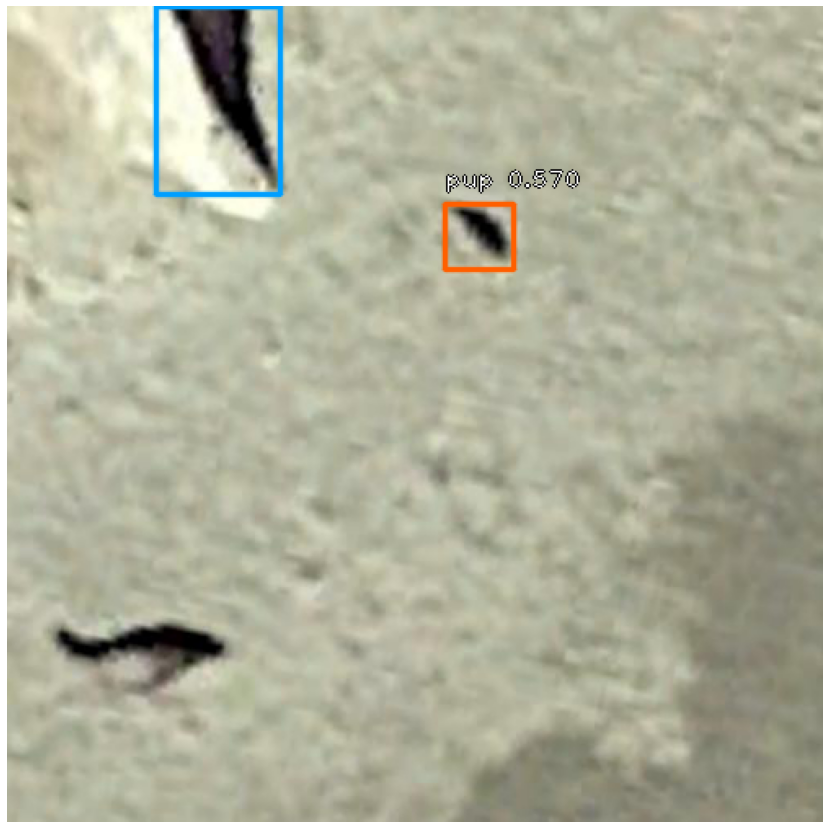

../Images/Elephant_Seals_Beach_Only/2_14_2018_es_db_59---67.png


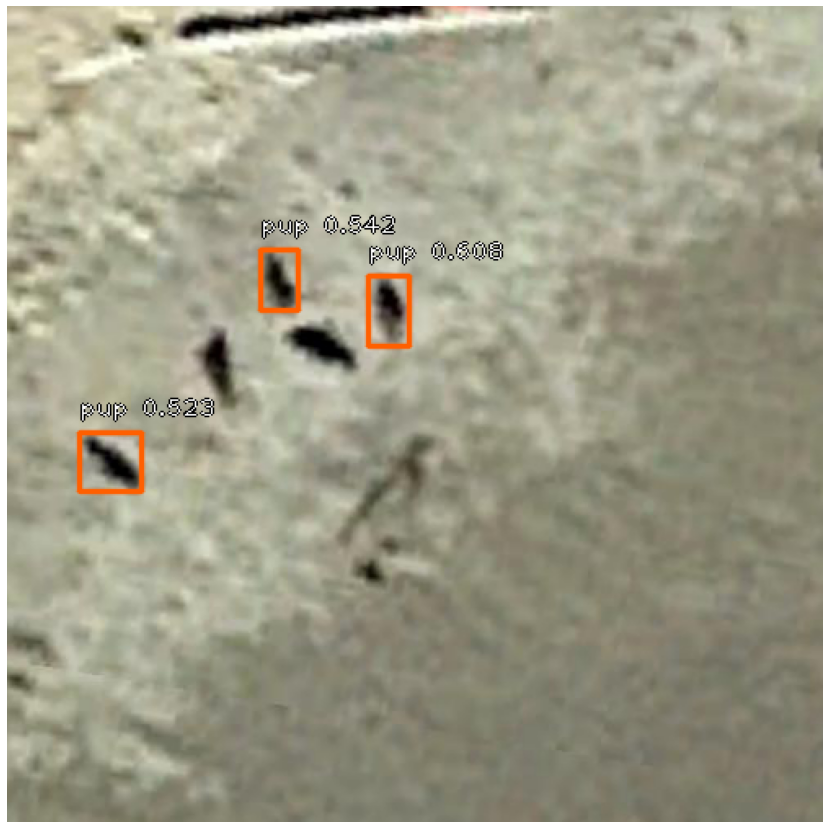

../Images/Elephant_Seals_Beach_Only/2_14_2018_es_db_62---26.png


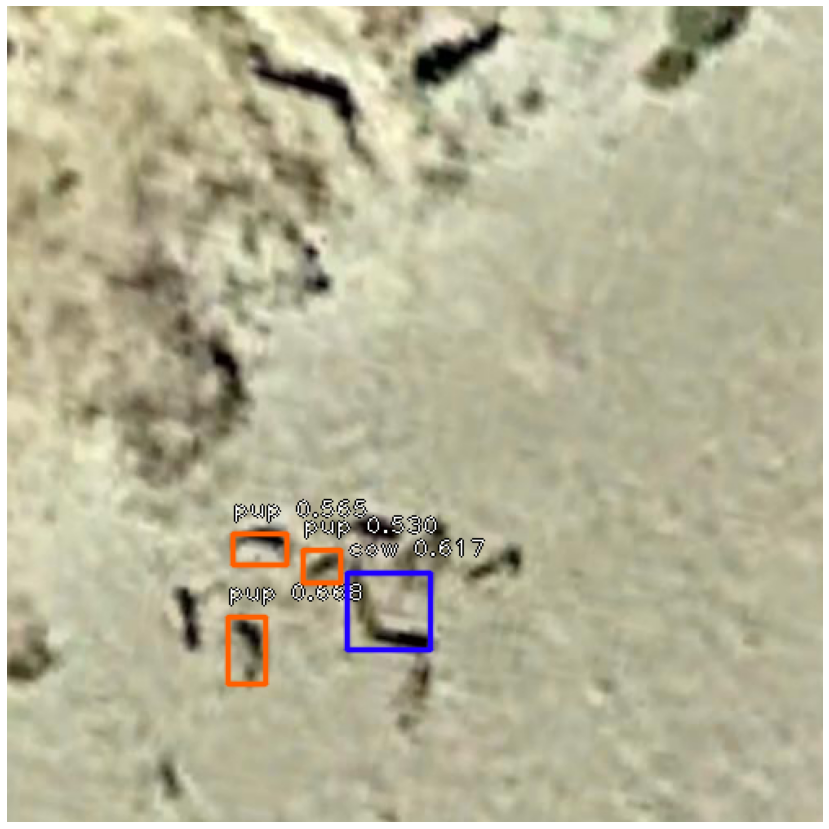

../Images/Elephant_Seals_Beach_Only/2_14_2018_es_db_68---2.png


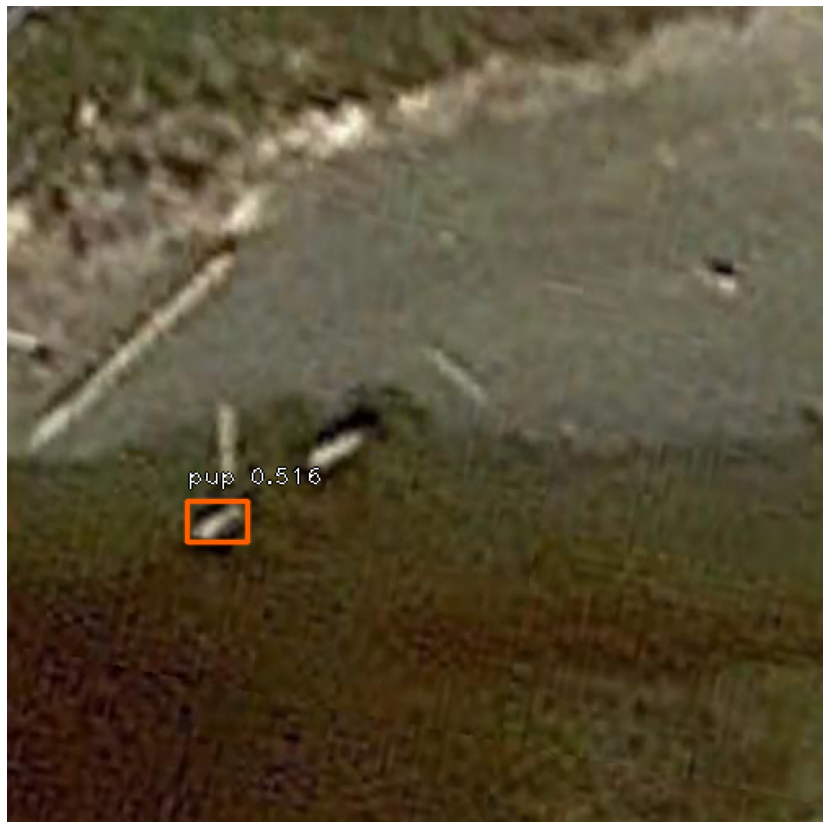

../Images/Elephant_Seals_Beach_Only/2_25_2021_es_db_26---99.png


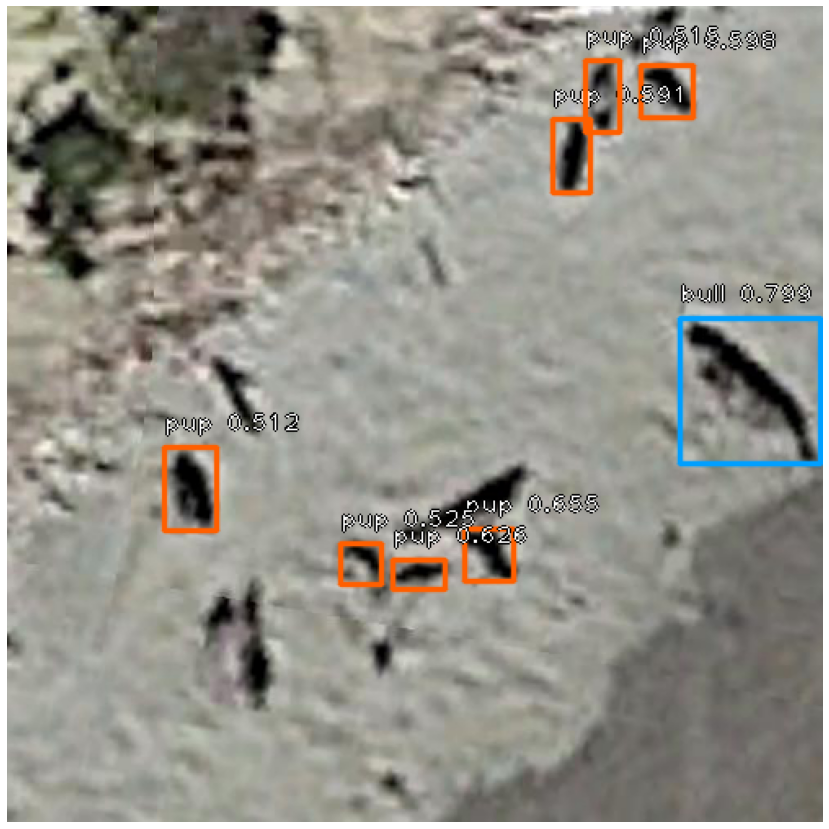

../Images/Elephant_Seals_Beach_Only/3_27_2015_es_pr_69---38.png


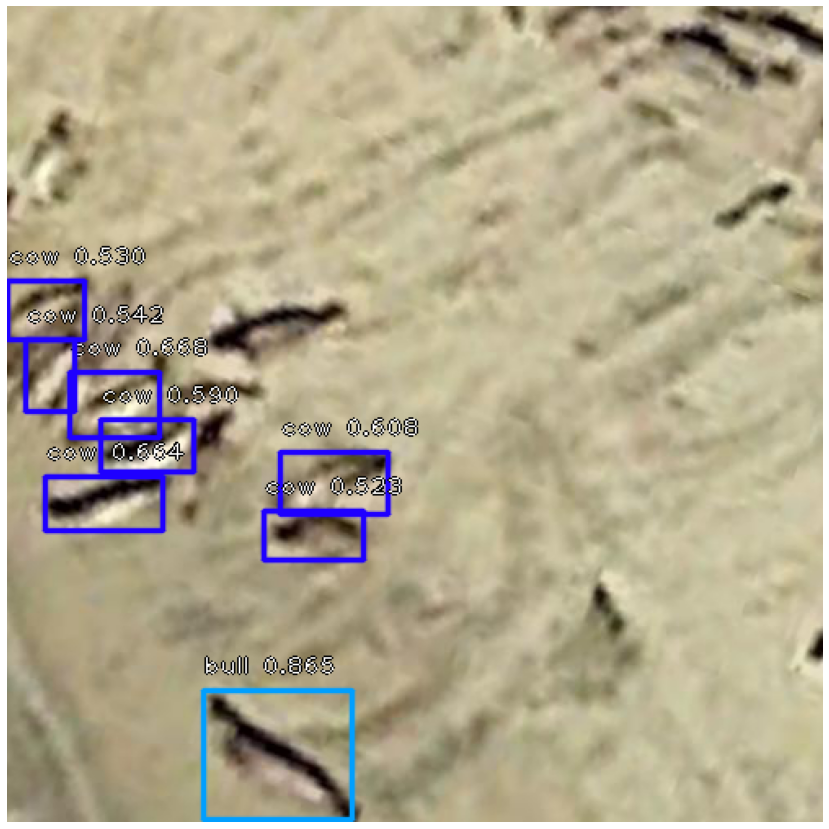

../Images/Elephant_Seals_Beach_Only/3_27_2015_es_pr_72---49.png


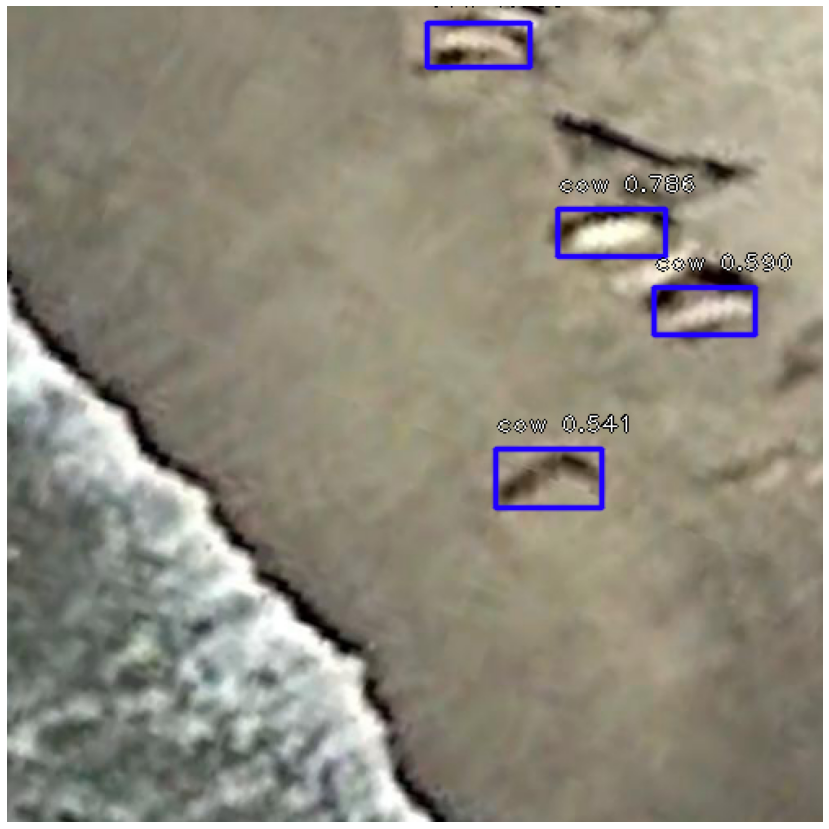

../Images/Elephant_Seals_Beach_Only/3_27_2015_es_pr_72---50.png


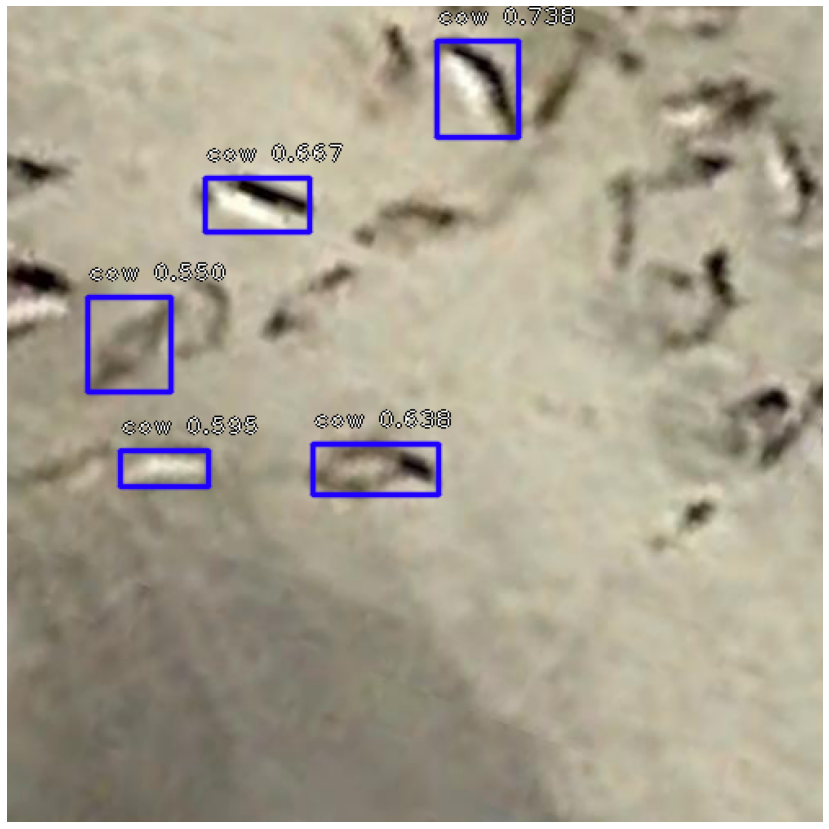

../Images/Elephant_Seals_Beach_Only/3_27_2015_es_pr_72---60.png has no seal annotations
Finished, time per image: 0.9953904416826036


In [25]:
visualize = True
min_score = 0.5

detections1 = {}

total_time = 0
labels_to_names = {0:"cow",1:"bull",2:"pup"}
for image_path in image_list: 
    im_name = image_path.split('/')[-1].split('.')[0] + '_output'
    
    image = read_image_bgr(image_path)
    
    if visualize:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    total_time += time.time() - start 
    
    boxes /= scale
    if any(score >= min_score for score in scores [0]):
        detections1[image_path] = []
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < min_score:
            break
        
        b = box.astype(int)
        detections1[image_path].append({"box" : b, "label" : label, "score" : score})
        
        if visualize: 
            color = label_color(label)
            
            draw_box(draw, b, color=color)
            
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            
    if any(score >= min_score for score in scores[0]):
        if visualize:
            print(image_path)
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.savefig(im_name + '.png')
            plt.show()
    else:
        print(image_path, "has no seal annotations")
print("Finished, time per image:", total_time/len(image_list))